In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import wandb
from PIL import Image
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch import nn
from torch.utils.data import DataLoader, random_split
from torcheval.metrics import MulticlassAccuracy
from torchvision import datasets, transforms
from tqdm import tqdm


## Data Loading


In [3]:
# set up the transform to resize the images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 64

# get labels from folder names
dataset = datasets.ImageFolder(root="data", transform=transform)

# create random train test split from data
rand_generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [0.8, 0.1, 0.1], generator=rand_generator
)
print(f"{len(train_dataset)} training images")
print(f"{len(val_dataset)} validation images")
print(f"{len(test_dataset)} testing images")


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


4885 training images
611 validation images
610 testing images


In [4]:
# show the encoding for each class label
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

{0: 'afghan', 1: 'chinese', 2: 'indian', 3: 'modern', 4: 'moroccan', 5: 'persian', 6: 'turkish'}


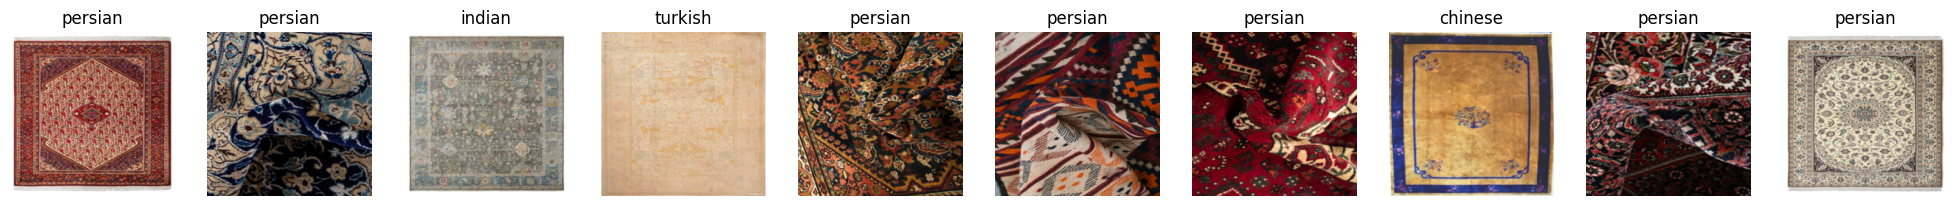

In [5]:
# convert tensor to numpy and plot as image
def imshow(image, ax=None, title=None) -> None:
    if ax is None:
        fig, ax = plt.subplots()
    # unnormalize the image
    image = image / 2 + 0.5
    image = image.numpy().transpose((1, 2, 0))
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis("off")


# plot training images
images, labels = next(iter(train_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()


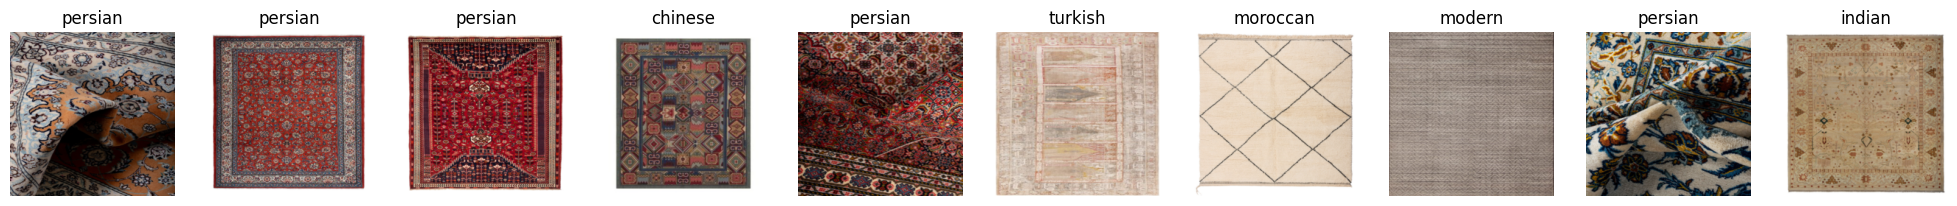

In [6]:
# plot validation images
images, labels = next(iter(val_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()

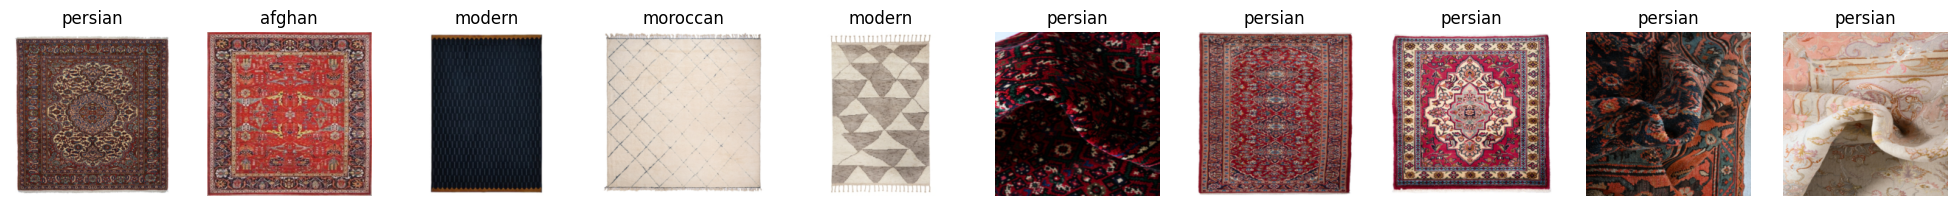

In [7]:
# plot test images
images, labels = next(iter(test_dataloader))
fig, axes = plt.subplots(1, 10, figsize=(25, 25))
for i in range(10):
    class_name = idx_to_class[int(labels[i])]
    imshow(images[i], ax=axes[i], title=class_name)
plt.show()

In [ ]:
from collections import Counter

# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in train_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
print(f"Train dataset has:")
class_counts = []
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    # get list of class counts for use in weighted focal loss
    class_counts.append(count)
    print(f"Class {class_name} has {count} instances")
print(f"Class count: {class_counts}")


Train dataset has:
Class persian has 3274 instances
Class count: [3274]
Class indian has 179 instances
Class count: [3274, 179]
Class afghan has 418 instances
Class count: [3274, 179, 418]
Class moroccan has 348 instances
Class count: [3274, 179, 418, 348]
Class turkish has 159 instances
Class count: [3274, 179, 418, 348, 159]
Class modern has 331 instances
Class count: [3274, 179, 418, 348, 159, 331]
Class chinese has 176 instances
Class count: [3274, 179, 418, 348, 159, 331, 176]


In [9]:
# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in val_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
print(f"Validaiton dataset has:")
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")

Validaiton dataset has:
Class modern has 47 instances
Class persian has 398 instances
Class moroccan has 38 instances
Class afghan has 57 instances
Class chinese has 23 instances
Class indian has 24 instances
Class turkish has 24 instances


In [10]:
from collections import Counter

# Initialize a Counter to count instances
label_counts = Counter()

# Loop over the DataLoader to get the labels
for _, labels in test_dataloader:
    label_counts.update(labels.tolist())

# Convert the dataset class indices to class names
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the counts for each class
print(f"Test dataset has:")
for label, count in label_counts.items():
    class_name = idx_to_class[label]
    print(f"Class {class_name} has {count} instances")

Test dataset has:
Class persian has 413 instances
Class afghan has 51 instances
Class chinese has 19 instances
Class modern has 56 instances
Class moroccan has 48 instances
Class turkish has 10 instances
Class indian has 13 instances


## Model


In [11]:
class NeuralNetworkWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(dataset.class_to_idx))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


model = NeuralNetworkWithDropout()

In [22]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super().__init__()

        # Initial layer
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),
        )

        # First block
        self.block1 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )

        # Second block
        self.block2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )

        # Third block
        self.block3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.4),
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes),
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

# Create model with all rug classes
model = ImprovedCNN(num_classes=len(dataset.class_to_idx))

## Optimizer, loss and accuracy


In [23]:
# implement focal loss to address the class imbalance
class WeightedFocalLoss(nn.Module):
    """Implement weighted focal loss to address the class imbalance in the data. Focal loss
    will adjust the loss by giving a higher weight to samples with lower probability
    of being correctly classified and a lower frequency in the training data.

    https://arxiv.org/pdf/1708.02002
    https://pytorch.org/vision/stable/_modules/torchvision/ops/focal_loss.html
    """

    def __init__(self, alpha=None, gamma=2, reduction="mean"):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.name = "Weighted Focal Loss"

    def forward(self, inputs, targets):
        # calculate standard cross entropy with class weights
        if self.alpha is not None:
            # Move alpha to the same device as inputs
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            BCE_loss = F.cross_entropy(
                inputs,
                targets,
                weight=self.alpha,
                reduction="none",
            )
        else:
            BCE_loss = F.cross_entropy(inputs, targets, reduction="none")

        # prevent NaNs when probability is 0 by computing probability of true class
        prob_true = torch.exp(-BCE_loss)

        # Calculate focal term: (1-pt)^gamma
        focal_term = (1 - prob_true) ** self.gamma

        # combine focal term with CE loss
        F_loss = focal_term * BCE_loss

        # apply reduction
        if self.reduction == "none":
            return F_loss
        elif self.reduction == "mean":
            return torch.mean(F_loss)
        elif self.reduction == "sum":
            return torch.sum(F_loss)
        else:
            msg = f"An invalid mode was selected for 'reduction': {self.reduction} \n Supported reduction values: 'none', 'mean', 'sum'"
            raise ValueError(msg)


def calculate_class_weights(class_counts):
    """Calculate class weights inversely proportional to class frequencies."""
    total_samples = sum(class_counts)
    return torch.FloatTensor(
        [total_samples / (len(class_counts) * count) for count in class_counts],
    )


class_weights = calculate_class_weights(class_counts)
focal_loss = WeightedFocalLoss(alpha=class_weights, gamma=3)

In [24]:
learning_rate = 0.02
# loss_fn = nn.CrossEntropyLoss()
loss_fn = focal_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [25]:
def get_loss_fn_params(loss_fn):
    # Extract alpha, gamma, and reduction parameters from the loss function, if available
    params = {}
    for attr in ["alpha", "gamma", "reduction"]:
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params


def initialize_wandb(model, train_dataloader, learning_rate, epochs, loss_fn, patience):
    config = {
        "learning_rate": learning_rate,
        "architecture": model.__class__.__name__,
        "dataset": "rugs",
        "epochs": epochs,
        "batch_size": train_dataloader.batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "patience": patience,
    }

    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            config[name] = {
                "in_channels"
                if isinstance(module, nn.Conv2d)
                else "in_features": module.in_channels
                if isinstance(module, nn.Conv2d)
                else module.in_features,
                "out_channels"
                if isinstance(module, nn.Conv2d)
                else "out_features": module.out_channels
                if isinstance(module, nn.Conv2d)
                else module.out_features,
            }
        if isinstance(module, nn.Dropout):
            config[f"{name}_dropout_rate"] = module.p

    loss_fn_params = get_loss_fn_params(loss_fn)
    config.update(loss_fn_params)

    wandb.init(
        project="rugai",
        config=config,
    )

## Training


In [26]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs,
    device,
    num_classes,
    model_name,
    checkpoint_dir,
    early_stopping_patience=None,
):
    """
    Training loop with wandb integration and MulticlassAccuracy metric

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        optimizer: Optimizer
        num_epochs: Maximum number of epochs
        device: Device to train on ('cuda' or 'cpu')
        project_name: WandB project name
        model_name: Name for saving model checkpoints
        num_classes: Number of classes for accuracy metric
        save_every: Save model every N epochs
        early_stopping_patience: Number of epochs to wait before early stopping
    """

    # Initialize wandb
    initialize_wandb(
        model,
        train_loader,
        learning_rate,
        num_epochs,
        criterion,
        early_stopping_patience,
    )

    print(f"Using {device} device")

    # Log model architecture
    wandb.watch(model)

    # Initialize accuracy metrics
    train_accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    val_accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)

    # Move model to device
    model = model.to(device)

    best_val_loss = float("inf")
    best_val_acc = 0.0
    patience_counter = 0

    # paths for saving models
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    best_model_path = os.path.join(checkpoint_dir, f"{model_name}_{timestamp}_best.pt")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (data, target) in enumerate(train_bar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss += loss.item()
            # Update accuracy metric (accumulates automatically)
            train_accuracy.update(output, target)

            # Get current accuracy for progress bar
            current_train_acc = train_accuracy.compute()

            # Update progress bar
            train_bar.set_postfix(
                {
                    "loss": f"{train_loss/(batch_idx+1):.4f}",
                    "acc": f"{100.*current_train_acc:.2f}%",
                }
            )

        # Get final training accuracy for the epoch
        final_train_acc = train_accuracy.compute()
        # Reset training accuracy for next epoch
        train_accuracy.reset()

        # Validation phase
        model.eval()
        val_loss = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for batch_idx, (data, target) in enumerate(val_bar):
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = criterion(output, target)

                # Update metrics
                val_loss += loss.item()
                # Update accuracy metric (accumulates automatically)
                val_accuracy.update(output, target)

                # Get current accuracy for progress bar
                current_val_acc = val_accuracy.compute()

                # Update progress bar
                val_bar.set_postfix(
                    {
                        "loss": f"{val_loss/(batch_idx+1):.4f}",
                        "acc": f"{100.*current_val_acc:.2f}%",
                    }
                )

        # Get final validation accuracy for the epoch
        final_val_acc = val_accuracy.compute()
        # Reset validation accuracy for next epoch
        val_accuracy.reset()

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)

        # Log metrics to wandb
        wandb.log(
            {
                "epoch": epoch + 1,
                "train_loss": epoch_train_loss,
                "train_acc": final_train_acc * 100,
                "val_loss": epoch_val_loss,
                "val_acc": final_val_acc * 100,
            }
        )

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_val_acc = final_val_acc
            patience_counter = 0

            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": epoch_train_loss,
                    "val_loss": epoch_val_loss,
                    "val_acc": final_val_acc,
                    "best_val_loss": best_val_loss,
                    "best_val_acc": best_val_acc,
                },
                best_model_path,
            )

            # Log model checkpoint to wandb
            wandb.save(best_model_path)

            print(
                f"Epoch {epoch + 1}: New best model saved to {best_model_path} with val_loss: {best_val_loss:.4f}, val_acc: {best_val_acc:.4f}"
            )
        else:
            patience_counter += 1

        # Early stopping
        if early_stopping_patience and patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

    wandb.finish()
    return model


# Train the model
trained_model = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=loss_fn,
    optimizer=optimizer,
    num_epochs=300,
    device=torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu",
    ),
    num_classes=len(class_to_idx),
    model_name=model.__class__.__name__,
    checkpoint_dir="model/ckpt",
    early_stopping_patience=10,
)

Using mps device


Epoch 1/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it, loss=1.9436, acc=65.63%]


Epoch 1: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.9436, val_acc: 0.6563


Epoch 2/300 [Val]: 100%|██████████| 10/10 [00:21<00:00,  2.18s/it, loss=1.8023, acc=70.05%]


Epoch 2: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.8023, val_acc: 0.7005


Epoch 5/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it, loss=1.5310, acc=69.72%]


Epoch 5: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.5310, val_acc: 0.6972


Epoch 6/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it, loss=1.3525, acc=71.36%]


Epoch 6: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.3525, val_acc: 0.7136


Epoch 9/300 [Val]: 100%|██████████| 10/10 [00:23<00:00,  2.37s/it, loss=1.2697, acc=71.52%]


Epoch 9: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.2697, val_acc: 0.7152


Epoch 11/300 [Val]: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it, loss=1.1919, acc=73.16%]


Epoch 11: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.1919, val_acc: 0.7316


Epoch 16/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it, loss=1.1762, acc=73.49%]


Epoch 16: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.1762, val_acc: 0.7349


Epoch 18/300 [Val]: 100%|██████████| 10/10 [00:21<00:00,  2.12s/it, loss=1.0469, acc=74.47%]


Epoch 18: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.0469, val_acc: 0.7447


Epoch 22/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.05s/it, loss=1.0411, acc=75.94%]


Epoch 22: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.0411, val_acc: 0.7594


Epoch 23/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it, loss=1.0301, acc=75.45%]


Epoch 23: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 1.0301, val_acc: 0.7545


Epoch 24/300 [Val]: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it, loss=0.8913, acc=77.09%]


Epoch 24: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.8913, val_acc: 0.7709


Epoch 34/300 [Val]: 100%|██████████| 10/10 [00:25<00:00,  2.53s/it, loss=0.8784, acc=76.76%]


Epoch 34: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.8784, val_acc: 0.7676


Epoch 38/300 [Val]: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it, loss=0.8416, acc=78.23%]


Epoch 38: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.8416, val_acc: 0.7823


Epoch 40/300 [Val]: 100%|██████████| 10/10 [00:23<00:00,  2.32s/it, loss=0.8386, acc=77.91%]


Epoch 40: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.8386, val_acc: 0.7791


Epoch 41/300 [Val]: 100%|██████████| 10/10 [00:21<00:00,  2.13s/it, loss=0.7685, acc=79.05%]


Epoch 41: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.7685, val_acc: 0.7905


Epoch 46/300 [Val]: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it, loss=0.7459, acc=78.72%]


Epoch 46: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.7459, val_acc: 0.7872


Epoch 52/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.10s/it, loss=0.7050, acc=79.54%]


Epoch 52: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.7050, val_acc: 0.7954


Epoch 61/300 [Val]: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it, loss=0.6556, acc=80.03%]


Epoch 61: New best model saved to model/ckpt/ImprovedCNN_20241124_121634_best.pt with val_loss: 0.6556, val_acc: 0.8003


Epoch 71/300 [Val]: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it, loss=0.7088, acc=80.03%]


Early stopping triggered after 71 epochs


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
train_acc,▁▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇█████▇▇█████
train_loss,█▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▄▄▅▄▅▅▆▅▆▅▆▆▆▆▇▇▆▇▆▇▇▆▇███▇▇██████▇█
val_loss,█▅▄▅▅▄▄▄▃▃▂▃▃▃▂▃▃▂▃▂▂▂▅▂▂▁▂▂▂▁▁▁▃▂▁▁▂▁▂▁
epoch,71
train_acc,80.69601
train_loss,0.68959
val_acc,80.03274
val_loss,0.70882


## Testing


In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [28]:
# Assuming class_to_idx is already defined
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Set the model to evaluation mode
model.eval()

# Retrieve a single image and label from the test dataloader
images, labels = next(iter(test_dataloader))
images, labels = images.to(device), labels.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Print the predicted label for the first image
image = images[0]
predicted_label = preds[0].item()
true_label = labels[0].item()

print(f"Predicted: {idx_to_class[predicted_label]}, True: {idx_to_class[true_label]}")

Predicted: persian, True: persian


## Predict on single image


In [29]:
# Assuming class_to_idx and your model are already defined
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}


# Load an arbitrary image
def load_image(image_path):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add a batch dimension
    return image


# Predict the class for the given image
def predict_image_class(image_path, model):
    image = load_image(image_path).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_class = predicted.item()
        class_name = idx_to_class[predicted_class]
        return class_name


# Example usage
image_path = "predict/IMG_2341.jpg"
predicted_class_name = predict_image_class(image_path, model)
print(f"The predicted class for the image is: {predicted_class_name}")

The predicted class for the image is: persian


### Evaluation of Test Data


In [30]:
def evaluate_model(all_preds, all_labels, num_classes, device="mps"):
    """
    Evaluate model predictions using MulticlassAccuracy

    Args:
        all_preds: Predictions array/tensor (numpy array or torch tensor)
        all_labels: Ground truth labels array/tensor (numpy array or torch tensor)
        num_classes: Number of classes in the dataset
        device: Device to compute accuracy on ('cuda' or 'cpu')

    Returns:
        float: Accuracy score
    """
    # Convert numpy arrays to torch tensors if necessary
    if isinstance(all_preds, np.ndarray):
        all_preds = torch.from_numpy(all_preds)
    if isinstance(all_labels, np.ndarray):
        all_labels = torch.from_numpy(all_labels)

    # Ensure tensors are of type Long/int64
    all_preds = all_preds.long()
    all_labels = all_labels.long()

    # Move tensors to specified device
    all_preds = all_preds.to(device)
    all_labels = all_labels.to(device)

    # Initialize and compute accuracy
    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    accuracy.update(all_preds, all_labels)
    return accuracy.compute().item()

/Users/jacob/Library/Caches/pypoetry/virtualenvs/rugai-0fpEKXoe-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.4939
Recall: 0.4947
F1 Score: 0.4823
Accuracy: 0.8164
Class afghan - FPR: 0.0000, Recall: 0.0000
Class chinese - FPR: 0.0203, Recall: 0.3158
Class indian - FPR: 0.0067, Recall: 0.0769
Class modern - FPR: 0.0126, Recall: 0.5893
Class moroccan - FPR: 0.0409, Recall: 1.0000
Class persian - FPR: 0.3147, Recall: 0.9806
Class turkish - FPR: 0.0067, Recall: 0.5000


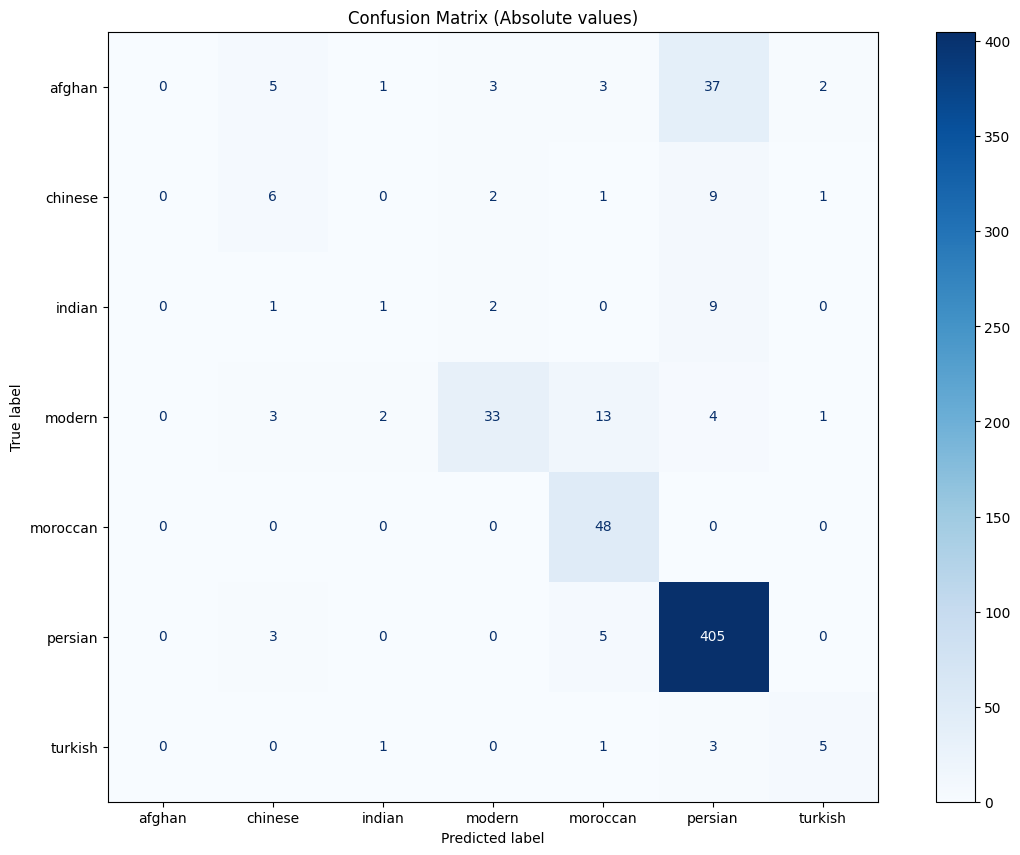

In [31]:
def get_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels


# Generate predictions
all_preds, all_labels = get_predictions(model, test_dataloader, device)

# Calculate precision, recall, and f1 scores
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")
accuracy = evaluate_model(all_preds, all_labels, len(idx_to_class), device)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate False Positive Rate for each class
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# False Positive Rate: FP / (FP + TN)
FPR = FP / (FP + TN)

# Recall: TP / (TP + FN)
Recall = TP / (TP + FN)

for i, fpr in enumerate(FPR):
    class_name = list(class_to_idx.keys())[i]
    print(f"Class {class_name} - FPR: {FPR[i]:.4f}, Recall: {Recall[i]:.4f}")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=list(class_to_idx.keys())
)
fig, ax = plt.subplots(figsize=(15, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix (Absolute values)")
plt.show()


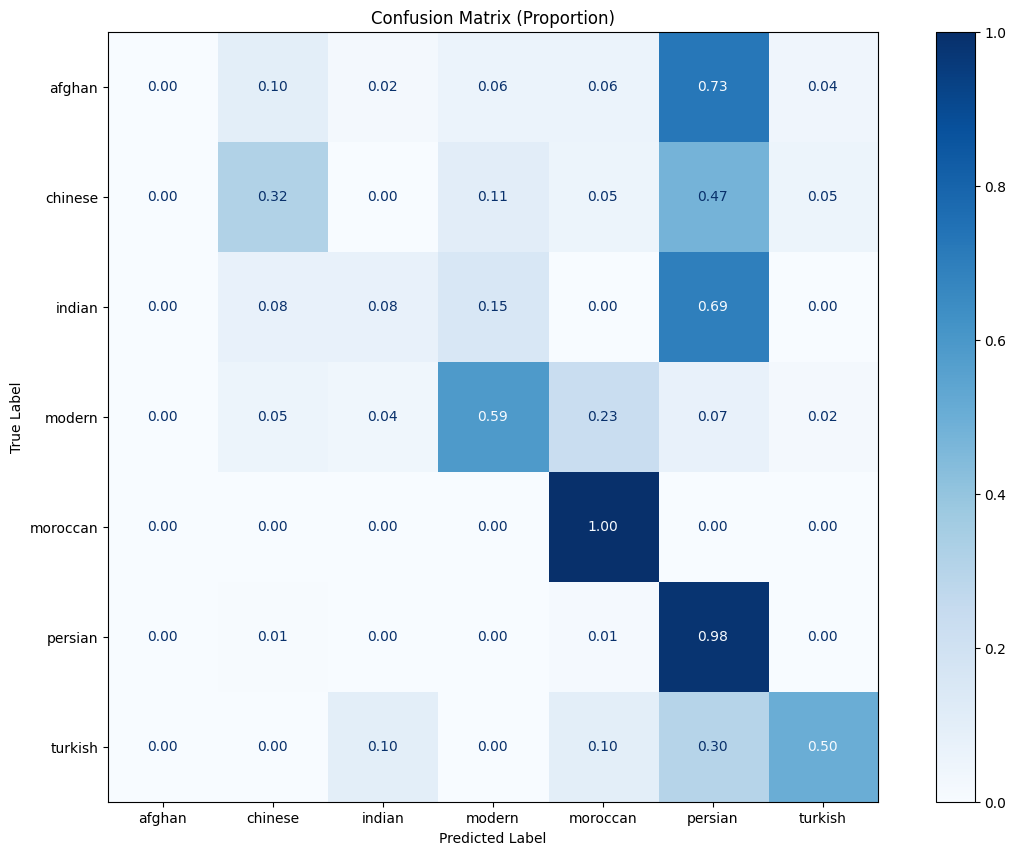

In [32]:
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(15, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized, display_labels=list(class_to_idx.keys())
)
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title("Confusion Matrix (Proportion)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.show()


In [33]:
checkpoint = torch.load(
            "/Users/jacob/Projects/rugai/model/ckpt/NeuralNetworkWithDropout_20241110_214240_best.pt"
        )
model_state_dict = checkpoint['model_state_dict']

/var/folders/hh/xhwgp6wd0qqdlbd59482n2gc0000gn/T/ipykernel_210/2957388514.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


In [10]:
torch.save(model_state_dict, 'NeuralNetworkWithDropout_20241110_214240_best.h5')